In [1]:
import os
import sys
import operator
import numpy as np
import pandas as pd
from scipy import sparse
import xgboost as xgb
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt

C:\Users\Yang\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=1000):
    param = {}
    param['objective'] = 'multi:softmax'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "merror"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain, 'training'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

def runXGBCV(train_X, train_y, feature_names=None, seed_val=0, num_rounds=100):
    param = {}
    param['objective'] = 'multi:softmax'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "merror"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    xgb.cv(plst, xgtrain, num_rounds, nfold=5, metrics={'merror'}, seed=0, 
           callbacks=[xgb.callback.print_evaluation(show_stdv=False)])

In [3]:
train_file = "train.json"
test_file = "test.json"
train_df = pd.read_json(train_file)
test_df = pd.read_json(test_file)
print(train_df.shape)
print(test_df.shape)

(49352, 15)
(74659, 14)


In [4]:
features_to_use  = ["bathrooms", "bedrooms", "latitude", "longitude", "price"]

In [5]:
# count of photos #
train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))

# convert the created column to datetime object so as to extract more features 
train_df["created"] = pd.to_datetime(train_df["created"])
test_df["created"] = pd.to_datetime(test_df["created"])

# Let us extract some features like year, month, day, hour from date columns #
train_df["created_year"] = train_df["created"].dt.year
test_df["created_year"] = test_df["created"].dt.year
train_df["created_month"] = train_df["created"].dt.month
test_df["created_month"] = test_df["created"].dt.month
train_df["created_day"] = train_df["created"].dt.day
test_df["created_day"] = test_df["created"].dt.day

# adding all these new features to use list #
features_to_use.extend(["num_photos", "num_features", "num_description_words","created_year", "created_month", "created_day", "listing_id"])

In [6]:
categorical = ["manager_id", "building_id"]
for f in categorical:
        if train_df[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            features_to_use.append(f)

In [7]:
train_df['features'] = train_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
test_df['features'] = test_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
print(train_df["features"].head())
tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df["features"])
te_sparse = tfidf.transform(test_df["features"])

10                                                         
10000     Doorman Elevator Fitness_Center Cats_Allowed D...
100004    Laundry_In_Building Dishwasher Hardwood_Floors...
100007                               Hardwood_Floors No_Fee
100013                                              Pre-War
Name: features, dtype: object


In [8]:
train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print(train_X.shape, test_X.shape)

(49352, 214) (74659, 214)


In [44]:
from sklearn.cross_validation import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.33)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

preds, model = runXGB(x_train, y_train, x_val, y_val)

(33065, 214) (33065,) (16287, 214) (16287,)
[0]	training-merror:0.281567	test-merror:0.289433
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 20 rounds.
[1]	training-merror:0.279964	test-merror:0.286609
[2]	training-merror:0.281294	test-merror:0.289863
[3]	training-merror:0.281536	test-merror:0.29017
[4]	training-merror:0.279994	test-merror:0.289924
[5]	training-merror:0.281204	test-merror:0.290231
[6]	training-merror:0.280145	test-merror:0.29017
[7]	training-merror:0.279752	test-merror:0.288881
[8]	training-merror:0.278875	test-merror:0.28839
[9]	training-merror:0.278935	test-merror:0.28839
[10]	training-merror:0.279056	test-merror:0.290293
[11]	training-merror:0.2783	test-merror:0.28931
[12]	training-merror:0.277212	test-merror:0.28839
[13]	training-merror:0.276637	test-merror:0.287714
[14]	training-merror:0.276818	test-merror:0.287284
[15]	training-merror:0.275609	test-merror:0.287346
[16]	traini

In [45]:
print(preds)
print(y_val)
print(preds.shape)
print(y_val.shape)

[ 2.  2.  2. ...,  2.  2.  2.]
[2 2 2 ..., 1 2 2]
(16287,)
(16287,)


In [70]:
from sklearn.metrics import classification_report

target_names = ['high', 'medium', 'low']
print(classification_report(preds, y_val, target_names=target_names))

             precision    recall  f1-score   support

       high       0.27      0.58      0.37       609
     medium       0.39      0.50      0.43      2886
        low       0.92      0.81      0.87     12792

avg / total       0.80      0.75      0.77     16287



In [71]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, preds)

array([[  355,   649,   294],
       [  196,  1429,  2073],
       [   58,   808, 10425]])

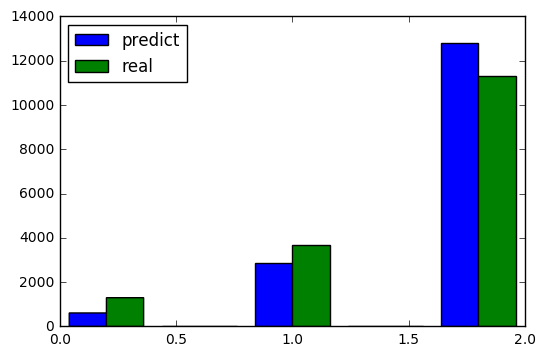

In [75]:
bins = np.linspace(0, 2, 6)
data = np.vstack([preds, y_val]).T
plt.hist(data, bins, alpha=1, label=['predict','real'])
plt.legend(loc='upper left')
plt.show()


In [73]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

y = label_binarize(y_val, classes=[0,1,2])
score = label_binarize(preds, classes=[0,1,2])
# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()

for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y[:, i],
                                                        score[:, i])
    average_precision[i] = average_precision_score(y[:, i], score[:, i])

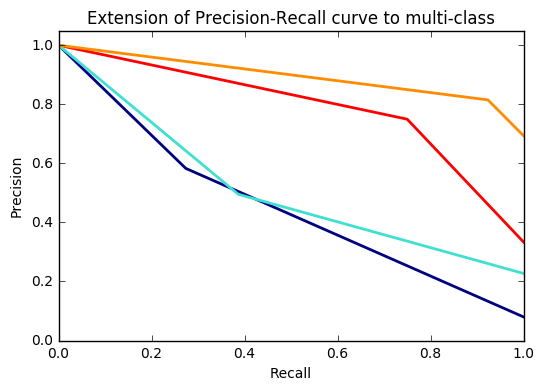

In [74]:
# Plot Precision-Recall curve for each class
from itertools import cycle
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
precision["micro"], recall["micro"], _ = precision_recall_curve(y.ravel(),score.ravel())
average_precision["micro"] = average_precision_score(y, score,average="micro")

plt.clf()
plt.plot(recall["micro"], precision["micro"], color='red', lw=2,
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i, color in zip(range(len(target_names)), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(target_names[i], average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
#plt.legend(loc="lower right")
plt.show()

In [17]:
#cv_scores = []
#kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
#for dev_index, val_index in kf.split(range(train_X.shape[0])):
#        dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
#        dev_y, val_y = train_y[dev_index], train_y[val_index]
#        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
#        cv_scores.append(log_loss(val_y, preds))
#        print(cv_scores)
#        break

In [61]:
y = label_binarize(y_val, classes=[0,1,2])
score = label_binarize(preds, classes=[0,1,2])

print(y[:,2])
print(score[:,2])

[1 1 1 ..., 0 1 1]
[1 1 1 ..., 1 1 1]


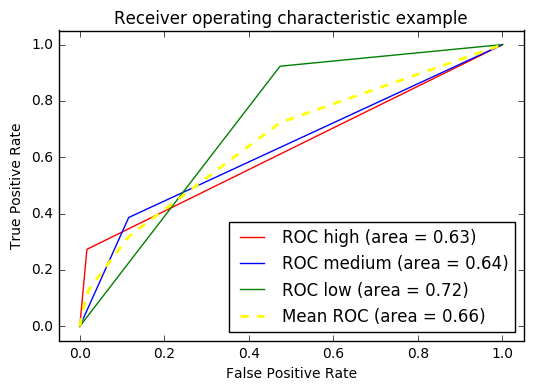

In [69]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
from scipy import interp

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
labels = ['high','medium','low']
colors = ['red', 'blue', 'green', 'yellow']

for i in range(3):
    fpr, tpr, _ = roc_curve(y[:,i], score[:,i])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, color=colors[i],
             label='ROC %s (area = %0.2f)' % (labels[i], roc_auc))

mean_tpr /= 3
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='yellow', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()